# **Emotional Analysis using Hugging Face Ecosystem**

## **Set Environment**

In this notebook, we have to install following additional libraries (compared to previous notebooks) from Huggingface  to enhance our workflow: **transformers**, **datasets**, **evaluate**, and **accelearte**. In addition, we are also installing **wandb**.

- The transformers library provides **Trainer** class that we will use to manage Training process.
- The **datasets** library simplifies the process of accessing and manipulating a wide array of datasets.
- The **evaluate** library offers a suite of standardized metrics and methods for robust and consistent model evaluation.
- We will not use **accelerate** library directly. However , we need to install it as transformer librray usses it in the background.
- Finally **wandb** library provide tools for efficient experiment tracking.

In [2]:
import sys
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  !pip install torchtext -qq
  # Install the torchinfo library quietly
  !pip install torchinfo -qq
  # !pip install torchtext --upgrade -qq
  !pip install torchmetrics -qq
  !pip install torchinfo -qq
  !pip install fast_ml -qq
  !pip install joblib -qq
  # !pip install sklearn -qq
  # !pip install pandas -qq
  # !pip install numpy -qq
  !pip install scikit-multilearn -qq
  !pip install transformers evaluate wandb accelerate -U -qq
  !pip install pytorch-ignite -qq -U

  basepath = '/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing'
  sys.path.append('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
else:
  basepath = '/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/'
  sys.path.append('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

### NEW ##########################
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_dataset
import evaluate

# wandb library
import wandb

<Font color = 'indianred'>*Specify Project Folders*

In [4]:
# base_folder = Path(basepath)
# data_folder = base_folder/'datasets/aclImdb'
# model_folder = base_folder/'models/nlp_spring_2024/imdb/nn'
# custom_functions = base_folder/'custom-functions'

# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / '0_Data_Folder'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = data_folder

custom_functions = base_folder / '0_Custom_files'

In [5]:
model_folder.mkdir(exist_ok=True, parents = True)

In [6]:
model_folder

PosixPath('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Data_Folder')

## **Loading data**

In [12]:
! chmod 600 /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/.kaggle/kaggle.json
!ls -la /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/.kaggle

total 1
-rw------- 1 root root 70 Nov 27 02:27 kaggle.json


In [13]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/.kaggle'

In [14]:
! kaggle competitions download -c emotion-detection-spring2014

  0% 0.00/609k [00:00<?, ?B/s]
100% 609k/609k [00:00<00:00, 44.3MB/s]


In [16]:
! unzip emotion-detection-spring2014.zip

Archive:  emotion-detection-spring2014.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [34]:
# Define the column names for labels
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Load train dataset
train_dataset = load_dataset('csv', data_files='train.csv', column_names=['ID', 'Tweet'] + label_columns)['train']

# Remove the 'ID' column
train_dataset = train_dataset.remove_columns('ID')
train_dataset

Dataset({
    features: ['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 7724
})

In [29]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [49]:
train_dataset

Dataset({
    features: ['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 7724
})

In [35]:
len(label_columns)

11

In [37]:
train_dataset.features

{'Tweet': Value(dtype='string', id=None),
 'anger': Value(dtype='int64', id=None),
 'anticipation': Value(dtype='int64', id=None),
 'disgust': Value(dtype='int64', id=None),
 'fear': Value(dtype='int64', id=None),
 'joy': Value(dtype='int64', id=None),
 'love': Value(dtype='int64', id=None),
 'optimism': Value(dtype='int64', id=None),
 'pessimism': Value(dtype='int64', id=None),
 'sadness': Value(dtype='int64', id=None),
 'surprise': Value(dtype='int64', id=None),
 'trust': Value(dtype='int64', id=None)}

In [38]:
train_dataset[1]

{'Tweet': 'Whatever you decide to do make sure it makes you #happy.',
 'anger': 0,
 'anticipation': 0,
 'disgust': 0,
 'fear': 0,
 'joy': 1,
 'love': 1,
 'optimism': 1,
 'pessimism': 0,
 'sadness': 0,
 'surprise': 0,
 'trust': 0}

In [42]:
import pandas as pd
pd.DataFrame(train_dataset['Tweet']).head()

,0
0,“Worry is a down payment on a problem you may ...
1,Whatever you decide to do make sure it makes y...
2,@Max_Kellerman it also helps that the majorit...
3,Accept the challenges so that you can literall...
4,My roommate: it's okay that we can't spell bec...


## **Create Custom Model and Model Config Class**

In [44]:
class CustomConfig(PretrainedConfig):
    def __init__(self, vocab_size=0, embedding_dim=256, hidden_dim1=512, hidden_dim2=256, num_labels=11, **kwargs):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.num_labels = num_labels

In [45]:
class CustomLSTM(PreTrainedModel):
    config_class = CustomConfig

    def __init__(self, config):
        super().__init__(config)

        self.embedding_bag = nn.EmbeddingBag(config.vocab_size, config.embedding_dim)
        self.lstm = nn.LSTM(config.embedding_dim, config.hidden_dim1, batch_first=True)
        self.layers = nn.Sequential(
            nn.Linear(config.hidden_dim1, config.hidden_dim2),
            nn.BatchNorm1d(num_features=config.hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim2, config.num_labels)  # 11 output labels
        )

    def forward(self, input_ids, offsets, labels=None):
        embed_out = self.embedding_bag(input_ids, offsets)
        lstm_out, _ = self.lstm(embed_out.unsqueeze(0))
        lstm_out = lstm_out.squeeze(0)
        logits = self.layers(lstm_out)

        loss = None
        if labels is not None:
            loss_fct = nn.BCELoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

## **Train Model**



### **Collate Function**

In [54]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (Dataset): A Hugging Face Dataset object. The dataset should
                           have a key 'texts' that contains the text data.
        min_freq (int): The minimum frequency for a token to be included in
                        the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object containing tokens from the
                               dataset that meet or exceed the specified
                               minimum frequency. It also includes a special
                               '<unk>' token for unknown words.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    # Iterating through texts in the dataset
    for text in dataset['Tweet']:  ###### Change from previous function ####
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [47]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(text, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(text).split()]

In [78]:
def collate_batch(batch, my_vocab):
    """
    Prepares a batch of data by transforming texts into indices based on a vocabulary and
    converting labels into a tensor.

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                              'optimism', 'pessimism', 'sadness', 'surprise', 'trust', and
                              'Tweet'. These keys represent the emotion labels and the text.
        my_vocab (torchtext.vocab.Vocab): A vocabulary object that maps tokens to indices.

    Returns:
        dict: A dictionary with three keys:
              - 'input_ids': a tensor containing concatenated indices of the texts.
              - 'offsets': a tensor representing the starting index of each text in 'input_ids'.
              - 'labels': a tensor of the emotion labels for each text in the batch.

    The function transforms each text into a list of indices based on the provided vocabulary.
    It also converts the labels into a tensor. The 'offsets' are computed to keep track of the
    start of each text within the 'input_ids' tensor, which is a flattened representation of all text indices.
    """

    # Get emotion labels and texts from batch dict samples
    labels = [[sample[label] for label in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                                           'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]
              for sample in batch]
    texts = [sample['Tweet'] for sample in batch]

    # Convert the list of labels into a tensor of dtype int64
    labels = torch.tensor(labels, dtype=torch.int64)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    input_ids = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return {
        'input_ids': input_ids,
        'offsets': offsets,
        'labels': labels
    }


In [79]:
tweet_vocab = get_vocab(train_dataset, min_freq=2)
collate_fn = partial(collate_batch, my_vocab=tweet_vocab)

### <Font color = 'indianred'>**5.2. Instantiate Model**
We will now specify the model using (1) model config class - `CustomConfig` and (2) model class - `CustomMLP`created earlier.

In [80]:
my_config = CustomConfig(vocab_size=len(tweet_vocab))

In [81]:
my_config

CustomConfig {
  "embedding_dim": 256,
  "hidden_dim1": 512,
  "hidden_dim2": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "transformers_version": "4.39.2",
  "vocab_size": 10344
}

In [82]:
my_config.id2label = {
    0: 'anger',
    1: 'anticipation',
    2: 'disgust',
    3: 'fear',
    4: 'joy',
    5: 'love',
    6: 'optimism',
    7: 'pessimism',
    8: 'sadness',
    9: 'surprise',
    10: 'trust'
}


In [83]:
# Generating id_to_label by reversing the key-value pairs in label_to_id
my_config.label2id = {v: k for k, v in my_config.id2label .items()}

In [84]:
my_config

CustomConfig {
  "embedding_dim": 256,
  "hidden_dim1": 512,
  "hidden_dim2": 256,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "transformers_version": "4.39.2",
  "vocab_size": 10344
}

In [85]:
model = CustomLSTM(config=my_config)

In [86]:
model

CustomLSTM(
  (embedding_bag): EmbeddingBag(10344, 256, mode='mean')
  (lstm): LSTM(256, 512, batch_first=True)
  (layers): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=11, bias=True)
  )
)

###  <font color = 'indianred'> **5.3. compute_metrics function** </font>
To provide context for the `compute_metrics` function, it's important to understand the shift in approach to model evaluation when using the Hugging Face `Trainer` compared to traditional methods:

*Role of `compute_metrics` Function in Hugging Face Ecosystem:*

- In the earlier notebook, model evaluation metrics like accuracy were explicitly calculated within the training and validation loops. This required manual coding of the metric computation, which can be complex and repetitive.

- With the Hugging Face `Trainer` (discussed later on), the process is simplified. The `Trainer` automates training, evaluation, and testing loops but requires a way to compute evaluation metrics. This is where the `compute_metrics` function comes into play.

- The `compute_metrics` function serves as a standardized way to calculate and return various evaluation metrics. It can be easily customized to include any metric supported by the `evaluate` module.
   
- This function is passed to the `Trainer` and is automatically called to compute metrics on the evaluation dataset.


In [87]:
def compute_metrics(eval_pred):
    metric = evaluate.load("f1", average="macro")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_score = metric.compute(predictions=predictions, references=labels)

    return {"f1": f1_score}

### <font color = 'indianred'> **5.4. Training Arguments**</font>

The `TrainingArguments` class in the Hugging Face Transformers library is a comprehensive configuration tool that defines a wide range of parameters for training machine learning models. The `TrainingArguments` class in Hugging Face is used to configure three key aspects of training machine learning models:

1. **Training-specific Configurations**: These settings define the core aspects of the training process. This include parameters like `epochs`, `batch seze` etc.

2. **Evaluation and Checkpoint Settings**: This group includes parameters for saving model checkpoints and evaluating the model's performance during training.

3. **Experiment Logging Configurations**: These settings are related to logging and tracking the training process.

In [88]:
# Configure training parameters
training_args = TrainingArguments(

    # Training-specific configurations
    num_train_epochs=5,
    per_device_train_batch_size=128, # Number of samples per training batch
    per_device_eval_batch_size=128, # Number of samples per validation batch
    weight_decay=0.1, # weight decay (L2 regularization)
    learning_rate=0.001, # learning arte
    optim='adamw_torch', # optimizer
    remove_unused_columns=False, # flag to retain unused columns

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='imdb_hf_trainer',  # Experiment name for Weights & Biases
)

1. *Training-Specific Parameters*:
  - `num_train_epochs=5`: Specifies the number of epochs
  - `per_device_train_batch_size=128` and `per_device_eval_batch_size=128`: Sets the batch size for training and evaluation.
  - `weight_decay=0.1`: Implements weight decay as a regularization technique, helping to prevent overfitting.
  - `learning_rate=0.001`: defines the learning rate.
  - `optim='adamw_torch'`: Chooses the AdamW optimizer from the PyTorch library.
  - `remove_unused_columns=False`: Ensures that the `Trainer` does not automatically remove columns from the dataset that are not directly used in the model's `forward` method. This is crucial in the current cintext because the `collate_batch` function relies on the `'texts'` and `'labels'` columns to preprocess the data into a format suitable for the `CustomMLP` model. This setting ensures that these essential columns are preserved through the data preparation process.

2. *Evaluation and Checkpointing related Parameters*:
  - `evaluation_strategy='steps'` and `eval_steps=50`: Sets up the model evaluation to occur at specified intervals, facilitating regular monitoring of model performance. Here we are evaluating model after 50 batches (steps).
  - `save_strategy="steps"` and `save_steps=50`: Determines the checkpointing frequency, crucial for long training sessions and recovery from interruptions. We are saving the model after every 50 batches.
  - `load_best_model_at_end=True`, `metric_for_best_model="accuracy"`, and `greater_is_better=True`: Configures the training to automatically identify and reload the best model based on the accuracy metric.
  - `output_dir=str(model_folder)` and `save_total_limit=2`: Specifies the directory for saving model checkpoints and limits the number of saved checkpoints to the best and most recent ones.

3. *Logging and Experiment Tracking related Parameters*:
  - `logging_strategy='steps'`, `logging_steps=50`, and `report_to='wandb'`: Sets up logging of metrics and results at specified intervals, and integrates with the Weights & Biases platform for comprehensive experiment tracking.







###  <font color = 'indianred'> **5.5. Initialize Trainer**</font>

The `Trainer` class, part of the Hugging Face's `transformers` library, acts as an all-in-one training and evaluation interface, designed to abstract and simplify the process of training, fine-tuning, and evaluating transformer models. Under the hood, the `Trainer` manages a plethora of tasks including:

- orchestrates model training loops,
- handles data loading and batching,
- applies gradient updates to model parameters,
- and evaluates model performance on validation datasets.
- it seamlessly integrates with provided training arguments to manage learning rates, optimization schedules, and model checkpointing.

By wrapping intricate details of the deep learning training cycle, the `Trainer` allows users to train state-of-the-art models with minimal configuration, focusing on high-level design and experimentation rather than the nuances of custom training loops.

In [89]:
# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
trainset, validset = train_dataset.train_test_split(test_size=valid_size)

In [90]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset = validset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### <Font color = 'indianred'>**5.5.Setup WandB**
Before we start training, we will log into WandB so that we can track our experiment.

In [91]:
wandb.login(key=userdata.get('wandb'))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [92]:
# specify the project name where the experiment will be logged
%env WANDB_PROJECT = nlp_course_spring_2024-emotion-analysis-hf-trainer-lstm

env: WANDB_PROJECT=nlp_course_spring_2024-emotion-analysis-hf-trainer-lstm


###  <font color = 'indianred'> **5.6. Training and Validation**</font>

In [93]:
trainer.train()

ValueError: invalid literal for int() with base 10: 'anger'

<font color = 'indianred'> *Evaluate model on Validation Set* </font>

Even though we have been evaluating the model periodically during training (e.g., every few epochs), trainer.evaluate() is typically used to perform a final, comprehensive evaluation after all training epochs are completed. This ensures that you assess the model's performance after it has been fully trained and using the best model. We can use these statistice to compare different experiments with different hyperparameters/models.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3519255518913269,
 'eval_accuracy': 0.8576,
 'eval_f1': 0.8601728201099765,
 'eval_runtime': 2.5386,
 'eval_samples_per_second': 1969.609,
 'eval_steps_per_second': 15.757,
 'epoch': 5.0}

<font color = 'indianred'> *Confusion Matrix*</font>

The metrics, while useful, do not always provide a complete picture of a model's performance. It's important to also examine the confusion matrix to gain insights into the specific types of errors the model is making, such as the frequency of false positives and false negatives. This deeper analysis helps in understanding the model's behavior across different classes and in fine-tuning its performance for more balanced and accurate predictions.

In [ ]:
valid_output = trainer.predict(validset)

In [ ]:
valid_output._fields

('predictions', 'label_ids', 'metrics')

The `valid_output` object returned by the `Trainer` class's `predict` method is structured as `('predictions', 'label_ids', 'metrics')`. `predictions` contain the model's raw logits or scores for each input in the validation set, from which predicted classes are derived. `label_ids` are the true labels for these inputs, essential for comparison and metric computation. `metrics` encompasses additional evaluation measures calculated from the model's predictions and actual labels, as defined in the `compute_metrics` function.

In [ ]:
valid_preds = np.argmax(valid_output.predictions, axis=-1)
valid_labels = np.array(valid_output.label_ids)

In [ ]:
def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, normalize='true')

    # Plot the confusion matrix using Seaborn
    # 'ax' represents the axes of the plot. Seaborn's heatmap is used for visualizing the confusion matrix
    # 'annot=True' displays the values in the cells, and 'fmt' specifies the string formatting for these values
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)

    # Rotating the tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Adding labels and title to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


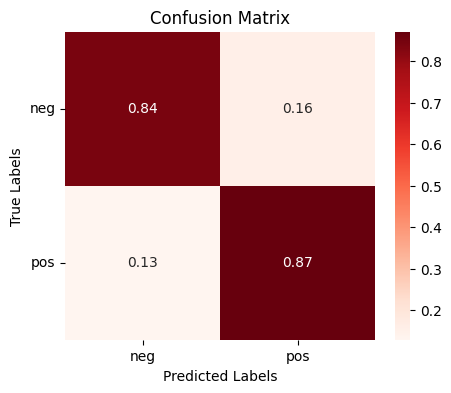

In [ ]:
plot_confusion_matrix(valid_labels, valid_preds, class_labels=list(my_config.id2label.values()))

In [ ]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=valid_preds, y_true=valid_labels,
    class_names=['neg', 'pos'])})


<font color = 'indianred'> *Get best checkpoint*</font>

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 700.


In [ ]:
wandb.finish()

eval/accuracy,▁▃▅▆▆▇▇▇████████
eval/f1,▁▃▅▆▆▇▇▇████████
eval/loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁
eval/runtime,▅▃▄▃▇▁▂█▁▁▆▃▁▄▄▃
eval/samples_per_second,▃▆▅▆▂█▆▁██▃▅▇▅▅▅
eval/steps_per_second,▃▆▅▆▂█▆▁██▃▅▇▅▅▅
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
train/grad_norm,█▅▃▂▂▃▃▃▁▂▃▂▂▂▄
train/learning_rate,██▇▆▆▅▅▅▄▄▃▃▂▂▁
train/loss,█▆▅▄▄▄▃▂▂▂▂▁▁▁▁


## <Font color = 'indianred'> **6. Performance on Test Set**

In the Model Evaluation stage, attention shifts to assessing the trained model's performance on unseen data, usually the test dataset. This phase generally follows the model training, marking a critical step in confirming the model's effectiveness and generalizability.

This stage is critical for assessing how well the model generalizes beyond the data it was trained on. The process involves:

1. **Loading the Best Model**: Load the checkpoint of the best model across different experiments. IN pour case we will select the best saved model from previos run.

2. **Setting Up the Trainer for Inference**: A new `Trainer` instance is configured with `TrainingArguments`. Here, training is disabled (`do_train = False`), and evaluation is enabled (`do_eval=True`), with other settings adjusted for the inference context, such as batch size and disabling of result logging.

3. **Evaluation and Prediction**: Using the `Trainer`, the model's performance is evaluated on the test dataset (`testset`). The `evaluate()` method computes metrics to assess the model, and `predict()` generates predictions, which are further processed to obtain final class labels and metrics.

4. **Visualizing Performance**: The confusion matrix is plotted to visually represent the model's classification accuracy on the test data, providing insights into its strengths and weaknesses in predicting different classes.

<Font color = 'indianred'> **Load Model from checkpoint**

In [ ]:
# Define the path to the best model checkpoint
# 'model_checkpoint' variable is constructed using the model folder path and the checkpoint step
# This step is identified as having the best model performance during training
model_checkpoint = model_folder/f'checkpoint-{best_model_checkpoint_step}'


In [ ]:
# Instantiate the CustomMLP model with predefined configurations
# 'my_config' is an instance of the CustomConfig class, containing specific model settings like
# vocabulary size, embedding dimensions, etc.
model = CustomMLP(my_config)


In [ ]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(36153, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
# Load the pre-trained weights into the CustomMLP model from the specified checkpoint
# 'model_checkpoint' refers to the path where the model's best-performing state is saved
# This step ensures the model is initialized with weights from its most effective training state
model = model.from_pretrained(model_checkpoint, config = my_config)


In [ ]:
model

CustomMLP(
  (embedding_bag): EmbeddingBag(36153, 300, mode='mean')
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

<Font color = 'indianred'> **Instantiate Trainer for evaluation**

In [ ]:
# Create a partial function 'collate_fn' using 'collate_batch' with 'my_vocab' set to 'imdb_vocab'
# This function will be used by the Trainer to process batches of data during evaluation
collate_fn = partial(collate_batch, my_vocab=imdb_vocab)

# Configure training arguments for model evaluation
# 'output_dir' specifies where to save the results
# 'per_device_eval_batch_size' sets the batch size for evaluation, adjusted based on available GPU memory
# 'do_train = False' and 'do_eval=True' indicate that training is not performed, but evaluation is
# 'remove_unused_columns=False' ensures that all columns in the dataset are retained during evaluation
# 'report_to=[]' disables logging to external services like Weights & Biases

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=True,
    remove_unused_columns=False,
    report_to=[]
)


In [ ]:
# Initialize the Trainer with the specified model and training arguments
# 'model' is the CustomMLP model loaded with pre-trained weights
# 'training_args' contains the configurations for evaluation, including batch sizes and output directory
# 'eval_dataset' is set to 'testset', which is the dataset used for evaluating the model
# 'data_collator' is assigned 'collate_fn', the function for processing batches of data
# 'compute_metrics' is a function that calculates evaluation metrics like accuracy and F1 score

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=testset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.evaluate()

{'eval_loss': 0.37968242168426514,
 'eval_accuracy': 0.8432,
 'eval_f1': 0.8424057248532605,
 'eval_runtime': 9.0882,
 'eval_samples_per_second': 2750.83,
 'eval_steps_per_second': 171.982}

In [ ]:
test_predictions = trainer.predict(testset)

In [ ]:
test_predictions._fields


('predictions', 'label_ids', 'metrics')

In [ ]:
test_predictions.metrics

{'test_loss': 0.37968242168426514,
 'test_accuracy': 0.8432,
 'test_f1': 0.8424057248532605,
 'test_runtime': 13.459,
 'test_samples_per_second': 1857.492,
 'test_steps_per_second': 116.13}

In [ ]:
test_predictions.label_ids

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
test_preds = np.argmax(test_predictions.predictions, axis=1)
test_labels = np.array(test_predictions.label_ids)

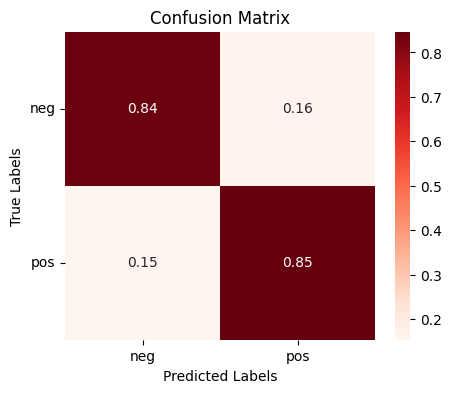

In [ ]:
plot_confusion_matrix(test_preds, test_labels, class_labels=list(my_config.id2label.values()))

## <Font color = 'indianred'> **7. Model Inference**
Model inference is the stage in the machine learning process where a trained model is used to make predictions on new, unseen data. Unlike the training or evaluation phases, labels are not required at this stage, as the primary goal is to apply the model's learned patterns and knowledge to generate predictions.




In [ ]:
sample_X = X_test_cleaned[0:5]

*Step 1. Preprocessing*

In [ ]:
device = 'cpu'
# Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
list_of_list_of_indices = [tokenizer(text, imdb_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

*Step 2: Get Predictions*

In [ ]:
# move model to appropriate device
model.to(device)

# put model in evaluation mode
model.eval()

# get outputs (logits) from model
outputs = model(indices, offsets)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-2.0745,  1.9437],
        [-1.7778,  1.7444],
        [-1.1749,  1.2411],
        [ 1.2903, -0.7448],
        [-2.0448,  2.1057]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits

tensor([[-2.0745,  1.9437],
        [-1.7778,  1.7444],
        [-1.1749,  1.2411],
        [ 1.2903, -0.7448],
        [-2.0448,  2.1057]], grad_fn=<AddmmBackward0>)

*Step 3: Post Processing*

In [ ]:
# get predicted labels
predictions = torch.argmax(outputs.logits, dim = 1)

# mapping for class labels
mapping = model.config.id2label

predicted_label_names = list(map(mapping.get, predictions.tolist()))

print(predicted_label_names)

['pos', 'pos', 'pos', 'neg', 'pos']
